# Tutorial 1A: DDPM
A diffusion model requires a UNet to process the input and produce the output at each step.

In [2]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=128,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

For training a diffusion model, in each iteration, we need a random noise which will be added to the training sample image. Note that we could also do batched training, but for this course we always assume batch size=1.

In [3]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

# fake training sample image, you can load your own
sample_image = torch.randn([1, 3, 128, 128])

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
# in each training iteration, sample a 't' value.
# here we use 50 as an example
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

The training objective of the model is to predict the noise added to the image. The loss at this step can be calculated by:

In [4]:
import torch.nn.functional as F
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

The training of a diffusion model is very time-consuming. If you are interested in training a diffusion model from scratch by yourself, please refer to https://huggingface.co/docs/diffusers/en/tutorials/basic_training.
DDPMPipeline can be applied to sample synthetic images according to the trained unet and the model configuration.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/143M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

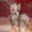

In [5]:
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from IPython.display import display

# google/ddpm-cifar10    google/ddpm-church-256
repo_id = "google/ddpm-cifar10"

# loading a pretrained unet
unet = UNet2DModel.from_pretrained(repo_id)
# loading the corresponding training configuration
scheduler = DDPMScheduler.from_config(repo_id)

ddpm_pipe = DDPMPipeline(unet, scheduler)

# ddpm_pipe.to("cuda")
res = ddpm_pipe()
image = res.images[0]

display(image)

We can also do the sampling step by step using the following code.

torch.Size([1, 3, 32, 32])


'Image at step 100'

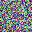

'Image at step 200'

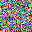

'Image at step 300'

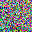

'Image at step 400'

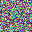

'Image at step 500'

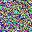

'Image at step 600'

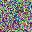

'Image at step 700'

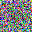

'Image at step 800'

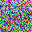

'Image at step 900'

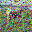

'Image at step 1000'

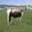

In [6]:
import PIL.Image
import numpy as np
import torch

def display_sample(sample, i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)
    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

noisy_sample=torch.randn(1, unet.config.in_channels, unet.config.sample_size,
                         unet.config.sample_size)

# unet.to("cuda")
# noisy_sample.to("cuda")

print(noisy_sample.shape)

sample=noisy_sample

for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        residual=unet(sample,t).sample

    # compute less noisy image and set x_t -> x_t-1
    sample =scheduler.step(residual, t, sample).prev_sample

    if (i+1)%100==0:
        display_sample(sample, i+1)

# Tutorial 1B: Latent Diffusion

### Using latent diffusion models to generate images according to text description.
Latent diffusion is applied to sample high-resolution images. An autoencoder is utilized to reduce the dimension of the input images for accelerating the sampling.

model_index.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

unet/config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

bert/config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.49G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vqvae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: Futu

  0%|          | 0/50 [00:00<?, ?it/s]

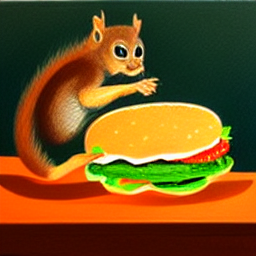

In [7]:
from diffusers import DiffusionPipeline
from IPython.display import display

ldm = DiffusionPipeline.from_pretrained("CompVis/ldm-text2im-large-256")
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=50, eta=0.3, guidance_scale=6).images

display(images[0])

  0%|          | 0/50 [00:00<?, ?it/s]

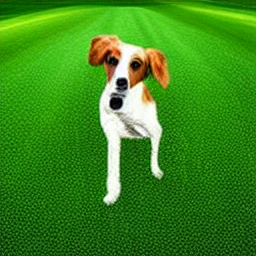

In [8]:
prompt = "A dog is running"
images = ldm([prompt], num_inference_steps=50, eta=0.3, guidance_scale=6).images

display(images[0])

  0%|          | 0/50 [00:00<?, ?it/s]

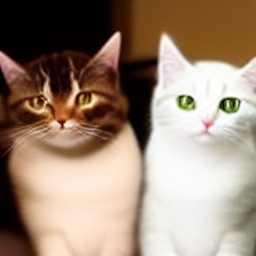

In [9]:
prompt = "Two lovely cats"
images = ldm([prompt], num_inference_steps=50, eta=0.3, guidance_scale=6).images

display(images[0])

### Defining a latent diffusion model step by step

In [10]:
# You'll need to install scipy for the following part
!conda install scipy -y

/bin/bash: line 1: conda: command not found


In [11]:
import torch, logging

## disable warnings
logging.disable(logging.WARNING)

## Imaging  library
from PIL import Image
from torchvision import transforms as tfms

## Basic libraries
import numpy as np
from tqdm.auto import tqdm

## Import the CLIP artifacts
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from IPython.display import display, clear_output
import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float16 if torch.cuda.is_available() else torch.float

In [12]:
## Initiating tokenizer and encoder.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=dtype).to(device)

## Initiating the VAE
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=dtype).to(device)

## Initializing a scheduler and Setting number of sampling steps
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(50)

## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=dtype).to(device)

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [13]:
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device=device, dtype=torch.float16)
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(latents):
    '''
    Function to convert latents to images
    '''
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(device))[0].to(dtype)


In [14]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to(device=device, dtype=dtype) * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")

        from IPython.display import display, clear_output
        if save_int and i%10==0:
            image_path = f'steps2/la_{i:04d}.jpeg'
            latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)


Processing text prompts: ['A dog wearing a hat']
Visualizing initial latents...
Initial Latents Norm: 1878.0


<ipython-input-14-6ffdc514738a>:20: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 1722.0
Step 2/70 Latents Norm: 1582.0
Step 3/70 Latents Norm: 1455.0
Step 4/70 Latents Norm: 1342.0
Step 5/70 Latents Norm: 1239.0
Step 6/70 Latents Norm: 1147.0
Step 7/70 Latents Norm: 1063.0
Step 8/70 Latents Norm: 986.5
Step 9/70 Latents Norm: 917.5
Step 10/70 Latents Norm: 854.5
Step 11/70 Latents Norm: 797.0
Step 12/70 Latents Norm: 745.0
Step 13/70 Latents Norm: 697.5
Step 14/70 Latents Norm: 654.0
Step 15/70 Latents Norm: 614.0
Step 16/70 Latents Norm: 577.5
Step 17/70 Latents Norm: 544.0
Step 18/70 Latents Norm: 513.5
Step 19/70 Latents Norm: 484.75
Step 20/70 Latents Norm: 458.75
Step 21/70 Latents Norm: 434.5
Step 22/70 Latents Norm: 412.25
Step 23/70 Latents Norm: 391.5
Step 24/70 Latents Norm: 372.5
Step 25/70 Latents Norm: 354.75
Step 26/70 Latents Norm: 338.25
Step 27/70 Latents Norm: 323.0
Step 28/70 Latents Norm: 308.75
Step 29/70 Latents Norm: 295.5
Step 30/70 Latents Norm: 283.25
Step 31/70 Latents Norm: 271.75
Step 32/70 Latents Norm: 261.0
St

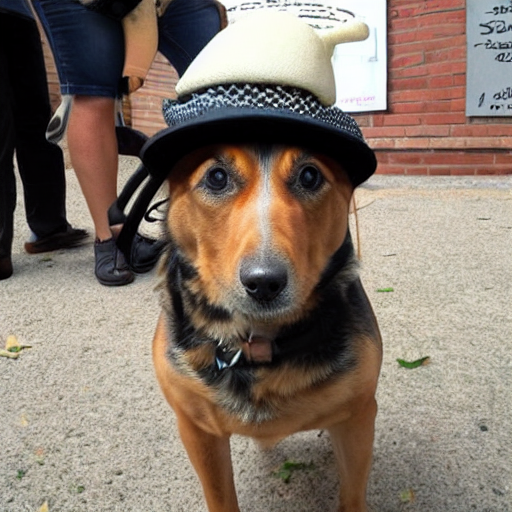

In [15]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False)
for img in images:
    display(img)

# Tutorial 2: Fast Diffusion
Diffusion models have a big challenge that the inference time for producing a synthetic image is too long. One of the basic reason is that there are too many required sampling steps for DDPMs.

In order to address this problem, we can apply DDIM to skip some sampling steps e.g., from step 10 directly to step 20 (sample the hidden variable of step 20 in condition with the sampled hidden variable of step 10) rather than go through 11, 12 ..., 19, 20.

# 2A: DDIM
DDIM is not a training method. It is a new sampling method rather than a new diffusion model. Therefore, when we apply DDIM, we can use DDPM to train the model then use DDIM to do the inference.

/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddim.DDIMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/50 [00:00<?, ?it/s]

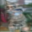

In [16]:
from diffusers import DDIMPipeline, DDIMScheduler, UNet2DModel
from IPython.display import display

# google/ddpm-cifar10    google/ddpm-church-256
repo_id = "google/ddpm-cifar10"

# loading a pretrained unet
unet = UNet2DModel.from_pretrained(repo_id)
# loading the corresponding training configuration
scheduler = DDIMScheduler.from_config(repo_id)

ddim_pipe = DDIMPipeline(unet, scheduler)

# ddim_pipe.to("cuda")

res = ddim_pipe(num_inference_steps=50)
image = res.images[0]

display(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

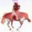

In [17]:
res = ddim_pipe(num_inference_steps=1000)
image = res.images[0]
display(image)

  0%|          | 0/100 [00:00<?, ?it/s]

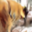

In [18]:
res = ddim_pipe(num_inference_steps=100)
image = res.images[0]
display(image)

  0%|          | 0/10 [00:00<?, ?it/s]

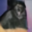

In [19]:
res = ddim_pipe(num_inference_steps=10)
image = res.images[0]
display(image)

  0%|          | 0/2 [00:00<?, ?it/s]

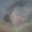

In [20]:
res = ddim_pipe(num_inference_steps=2)
image = res.images[0]
display(image)

There should be a trade-off between sampling steps and image quality.

For DDIM, we can visualize the full sampling stages using the following code.

torch.Size([1, 3, 32, 32])


'Image at step 10'

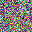

'Image at step 20'

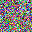

'Image at step 30'

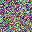

'Image at step 40'

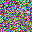

'Image at step 50'

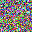

'Image at step 60'

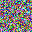

'Image at step 70'

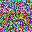

'Image at step 80'

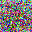

'Image at step 90'

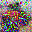

'Image at step 100'

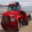

In [21]:
import PIL.Image
import numpy as np
import torch

def display_sample(sample, i):
    image_processed=sample.cpu().permute(0,2,3,1)
    image_processed=(image_processed+1.0)*127.5
    image_processed=image_processed.numpy().astype(np.uint8)
    image_pil=PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

noisy_sample=torch.randn(1, unet.config.in_channels, unet.config.sample_size,
                         unet.config.sample_size)

# unet.to("cuda")
# noisy_sample.to("cuda")

print(noisy_sample.shape)

scheduler.set_timesteps(100)
sample=noisy_sample

for i, t in enumerate(scheduler.timesteps):
    with torch.no_grad():
        residual=unet(sample,t).sample

    sample =scheduler.step(residual, t, sample).prev_sample

    if (i+1)%10==0:
        display_sample(sample, i+1)

DDIM is also applied on latent diffusion models, LDMs. We can choose the sampling steps of the inference of a LDM.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/unet.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-text2im-large-256/snapshots/30de525ca11a880baea4962827fb6cb0bb268955/vqvae.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False`

  0%|          | 0/200 [00:00<?, ?it/s]

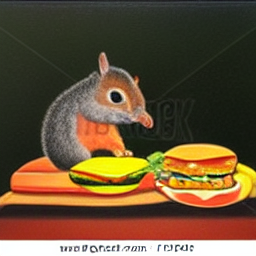

In [23]:
from diffusers import DiffusionPipeline
from IPython.display import display

ldm = DiffusionPipeline.from_pretrained("CompVis/ldm-text2im-large-256").to(device=device, dtype=dtype)
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=200, eta=0.3, guidance_scale=6).images

display(images[0])

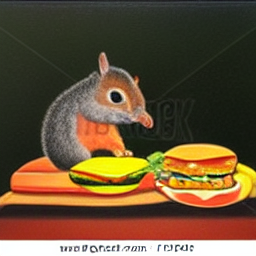

  0%|          | 0/20 [00:00<?, ?it/s]

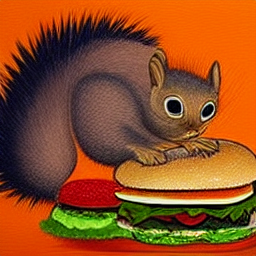

In [24]:
display(images[0])
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=20, eta=0.3, guidance_scale=6).images
display(images[0])

  0%|          | 0/5 [00:00<?, ?it/s]

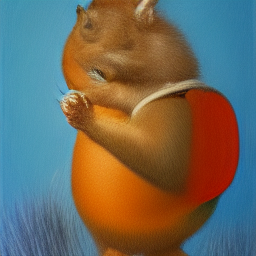

In [25]:
prompt = "A painting of a squirrel eating a burger"
images = ldm([prompt], num_inference_steps=5, eta=0.3, guidance_scale=6).images

display(images[0])

In [29]:
from IPython.display import display, clear_output
## Initializing the U-Net model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=dtype).to(device)

def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=True, scale_down=8):
    """
    Diffusion process to convert prompt to image
    """

    # Defining batch size
    bs = len(prompts)

    # Converting textual prompts to embedding
    text = text_enc(prompts)

    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])

    # Setting the seed
    if seed: torch.manual_seed(seed)

    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//scale_down, dim//scale_down))

    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)

    # Adding noise to the latents
    latents = latents.to(device=device, dtype=dtype) * scheduler.init_noise_sigma

    print("Processing text prompts:", prompts)
    # Just before the loop starts:
    print("Visualizing initial latents...")
    latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
    print(f"Initial Latents Norm: {latents_norm}")

    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # Performing Guidance
        pred = u + g*(t-u)

        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample

        # Inside your loop, after `latents` have been updated:
        latents_norm = torch.norm(latents.view(latents.shape[0], -1), dim=1).mean().item()
        print(f"Step {i+1}/{steps} Latents Norm: {latents_norm}")

        if save_int and i%10==0:
            # image_path = f'steps2/la_{i:04d}.jpeg'
            # latents_to_pil(latents)[0].save(image_path)
            display(latents_to_pil(latents)[0])  # Display the new image

    return latents_to_pil(latents)

Processing text prompts: ['A dog wearing a hat']
Visualizing initial latents...
Initial Latents Norm: 128.5


<ipython-input-29-a0017c0c3287>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//scale_down, dim//scale_down))


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 128.375
Step 2/70 Latents Norm: 128.625
Step 3/70 Latents Norm: 128.75
Step 4/70 Latents Norm: 129.125
Step 5/70 Latents Norm: 129.375
Step 6/70 Latents Norm: 129.875
Step 7/70 Latents Norm: 130.875
Step 8/70 Latents Norm: 133.625
Step 9/70 Latents Norm: 132.375
Step 10/70 Latents Norm: 133.125
Step 11/70 Latents Norm: 133.0
Step 12/70 Latents Norm: 140.0
Step 13/70 Latents Norm: 135.625
Step 14/70 Latents Norm: 134.375
Step 15/70 Latents Norm: 133.75
Step 16/70 Latents Norm: 133.625
Step 17/70 Latents Norm: 132.0
Step 18/70 Latents Norm: 137.875
Step 19/70 Latents Norm: 135.75
Step 20/70 Latents Norm: 135.5
Step 21/70 Latents Norm: 134.5
Step 22/70 Latents Norm: 133.0
Step 23/70 Latents Norm: 131.5
Step 24/70 Latents Norm: 131.25
Step 25/70 Latents Norm: 131.75
Step 26/70 Latents Norm: 132.625
Step 27/70 Latents Norm: 134.875
Step 28/70 Latents Norm: 133.625
Step 29/70 Latents Norm: 133.875
Step 30/70 Latents Norm: 130.5
Step 31/70 Latents Norm: 130.125
Step 32

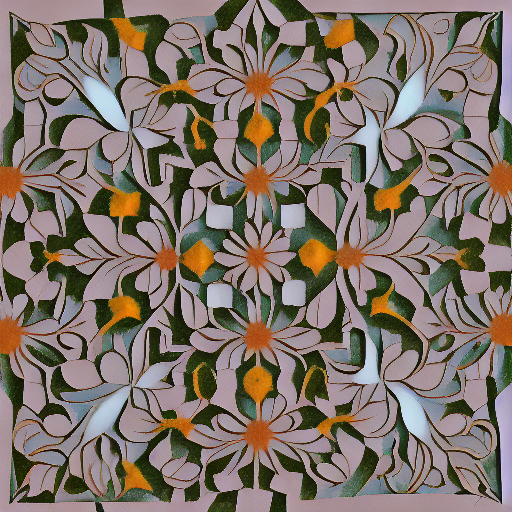

In [30]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False, scale_down=8)
for img in images:
    display(img)

Processing text prompts: ['A dog wearing a hat']
Visualizing initial latents...
Initial Latents Norm: 63.46875


<ipython-input-29-a0017c0c3287>:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//scale_down, dim//scale_down))


  0%|          | 0/70 [00:00<?, ?it/s]

Step 1/70 Latents Norm: 64.25
Step 2/70 Latents Norm: 66.6875
Step 3/70 Latents Norm: 65.375
Step 4/70 Latents Norm: 64.5625
Step 5/70 Latents Norm: 75.875
Step 6/70 Latents Norm: 69.4375
Step 7/70 Latents Norm: 66.6875
Step 8/70 Latents Norm: 65.125
Step 9/70 Latents Norm: 64.8125
Step 10/70 Latents Norm: 63.59375
Step 11/70 Latents Norm: 67.8125
Step 12/70 Latents Norm: 66.5
Step 13/70 Latents Norm: 65.25
Step 14/70 Latents Norm: 66.5625
Step 15/70 Latents Norm: 65.5625
Step 16/70 Latents Norm: 63.0
Step 17/70 Latents Norm: 74.6875
Step 18/70 Latents Norm: 70.875
Step 19/70 Latents Norm: 69.75
Step 20/70 Latents Norm: 68.375
Step 21/70 Latents Norm: 66.5625
Step 22/70 Latents Norm: 75.5
Step 23/70 Latents Norm: 70.3125
Step 24/70 Latents Norm: 68.125
Step 25/70 Latents Norm: 72.8125
Step 26/70 Latents Norm: 68.9375
Step 27/70 Latents Norm: 72.6875
Step 28/70 Latents Norm: 70.0
Step 29/70 Latents Norm: 75.5625
Step 30/70 Latents Norm: 69.75
Step 31/70 Latents Norm: 65.4375
Step 32/70 

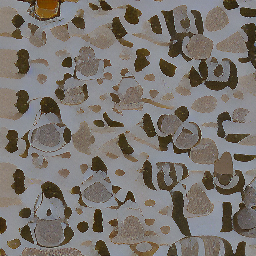

In [32]:
images = prompt_2_img(["A dog wearing a hat"], save_int=False, scale_down=16)
for img in images:
    display(img)